<a href="https://colab.research.google.com/github/nakib103/pancancer_classification/blob/master/grad_cam_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pickle
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data and label and model

data = pd.read_pickle("/content/drive/My Drive/data/data_df.pkl")
label = pd.read_pickle("/content/drive/My Drive/data/label_df.pkl")


# data_log_transformed = data.apply(lambda x: np.log2(x + 1))
# var = data_log_transformed.var(axis=0)
# ommit_feature = np.where( var < 1.19 )

model = load_model("/content/drive/My Drive/results/model_without_featreduction_2D_1.h5")

In [ ]:
last_conv_layer_name = "dropout_2"
classifier_layer_names = [
    "flatten",
    "dense",
    "dense_1",
    "dense_2",
    "dense_3",
]

In [ ]:
def make_gradcam_heatmap(
    sample, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(sample)
  
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 2, 3))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[i, :, :] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=0)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
def preprocess_input(sample, shape):
  sample_log_transformed = sample.apply(lambda x: np.log2(x + 1))

  # feature = data.columns
  # for idx in ommit_feature:
  #   sample_feature_reduced = sample_log_transformed.drop(feature[idx])

  x = sample_log_transformed.values
  x = np.pad(x, ((0, shape[0] * shape[1] - x.shape[0])), 'constant', constant_values=0)  
  x = np.reshape(x, (1, 1, shape[0], shape[1]))
  return x

In [ ]:
# Prepare image
class_data = data[label[0] == "COAD"]

for idx in range(class_data.shape[0]):
  sample_data = preprocess_input(class_data.iloc[idx], (150, 150))

  # Print what the top predicted class is
  preds = model.predict(sample_data)
  print("Predicted:", np.argmax(preds[0]))

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(
      sample_data, model, last_conv_layer_name, classifier_layer_names
  )

  try:
    overall_heatmap
    overall_heatmap = np.append(
      overall_heatmap,
      np.reshape(heatmap, (1, heatmap.shape[0], heatmap.shape[1])),
      axis = 0
  )
  except:
    overall_heatmap = np.reshape(heatmap, (1, heatmap.shape[0], heatmap.shape[1]))
  

# Display heatmap
# plt.matshow(heatmap)
# plt.show()

Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 25
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 25
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 17
Predicted: 25
Predicted: 17
Predicted: 17
Predicted: 17
Predic

In [ ]:
avg_heatmap = np.average(overall_heatmap, axis = 0)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * avg_heatmap)

import cv2
resized_heatmap = cv2.resize(heatmap, (150, 150), interpolation=cv2.INTER_AREA)

gene_rank = resized_heatmap.flatten().argsort()


rank = 500
for idx in range(rank):
  if gene_rank[idx] < 20531:
    print(data.columns[gene_rank[idx]])

CHRNA5|1138
CENPN|55839
CENPM|79019
CENPL|91687
CENPK|64105
CDH17|1015
CDH16|1014
CDH15|1013
CCR9|10803
CCDC37|348807
CCDC36|339834
CLECL1|160365
CLGN|1047
CASC1|55259
CA5B|11238
CASC2|255082
CASC4|113201
CASC5|57082
CLIC1|1192
CLIC2|1193
CLIC3|9022
CLIC4|25932
CLIC5|53405
CLIC6|54102
CASD1|64921
CASKIN1|57524
CASKIN2|57513
CCDC28B|79140
CCDC30|728621
CASC3|22794
CCDC33|80125
CA5BP|340591
CA4|762
CHRNA3|1136
CHRNA2|1135
CHRNA1|1134
CHRNA10|57053
CHRM5|1133
CHRM4|1132
CHRNA4|1137
CCRL1|51554
CCRL2|9034
CCRN4L|25819
CCS|9973
CCT2|10576
CCT3|7203
CCT4|10575
CDCP2|200008
CDH10|1008
CDH11|1009
CENPO|79172
CA3|761
CA2|760
CA1|759
CENPP|401541
CENPQ|55166
CA5A|763
CA14|23632
CDH13|1012
CCDC38|120935
CCDC39|339829
CDH12|1010
CENPT|80152
CCDC34|91057
ARID2|196528
ARID3A|1820
ARID4A|5926
ARID3C|138715
ASTN2|23245
ASTN1|460
ASTL|431705
ASS1|445
ASRGL1|80150
ASPSCR1|79058
ASPRV1|151516
ALAS2|212
ARID3B|10620
ALB|213
ALDH16A1|126133
ALDH18A1|5832
ALDH1A1|216
ALDH1A2|8854
ALDH1A3|220
ARID5B|84159
AR

In [ ]:
# superimposed_img = np.multiply(resized_heatmap * img)

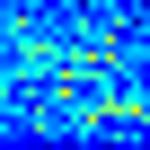

In [ ]:
# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((150, 150))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original data
# superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(jet_heatmap)

# Save the superimposed image
save_path = "/content/drive/My Drive/results/grad_cam/avg_class18.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))